C:\Users\singhy\AppData\Local\Temp\ipykernel_23152\3511187900.py:94: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wage_data = wage_data.fillna(1)


PermissionError: [Errno 13] Permission denied: 'C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output/figures/wage_index_trends_short_v2.pdf'

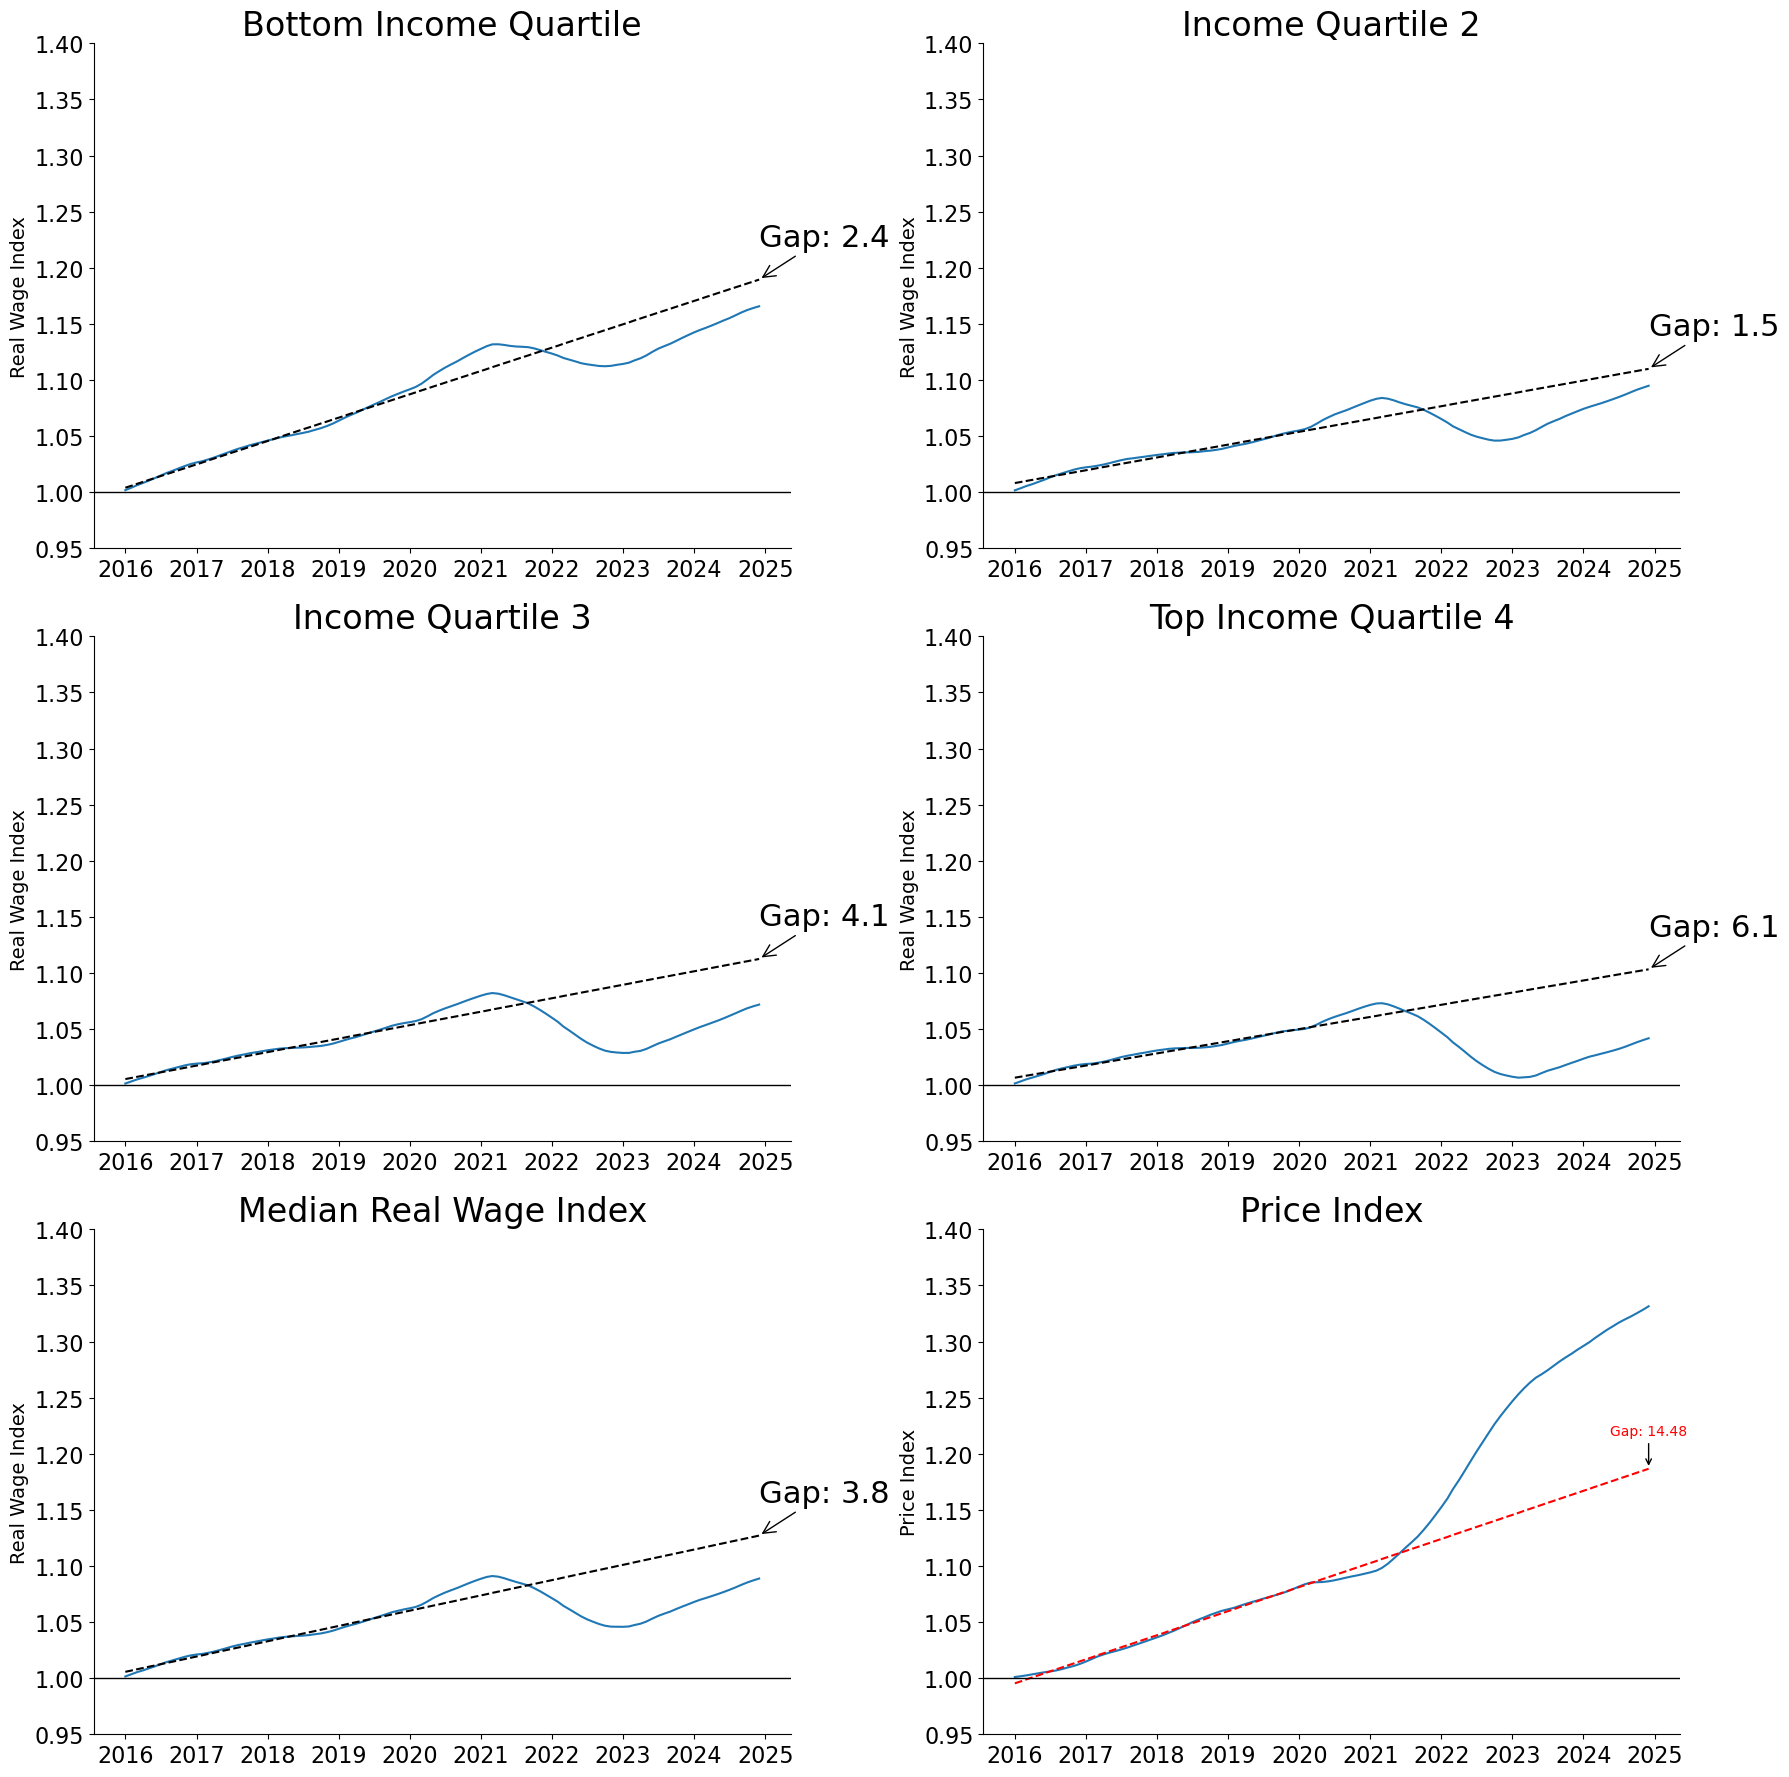

In [55]:
# Yash Singh 
# date: 11/1/2024 
# this script uses data from the Atlanta Fed Wage Tracker to construct real wage indices across the income distribution 

# Specify directories 
data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data"
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output"

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load data
data = pd.read_excel(f"{data_dir}/atl_fed/wage-growth-data.xlsx", sheet_name='Average Wage Quartile', skiprows=2, header=0)
cpi = pd.read_csv(f"{data_dir}/CPI/CPIAUCSL.csv")

# Set global styles
plt.rcParams.update({
    'font.size': 14,             # Set default font size
    'axes.titlesize': 24,        # Title font size
    'axes.labelsize': 20,        # Axis labels font size
    'legend.fontsize': 12,       # Legend font size
    'xtick.labelsize': 20,       # X-axis tick labels
    'ytick.labelsize': 20,       # Y-axis tick labels
    'legend.frameon': False,     # Remove legend box
    'axes.spines.top': False,    # Remove top spine
    'axes.spines.right': False,  # Remove right spine
})

# Atlanta Fed Wage Data 
data = data.rename(columns={
    'Unnamed: 0': 'date',
    'Lowest quartile of wage distribution': 'Q1',
    '2nd quartile of wage distribution': 'Q2', 
    '3rd quartile of wage distribution': 'Q3', 
    'Highest quartile of wage distribution': 'Q4'
})

select = ['date', 'Q1', 'Q2', 'Q3', 'Q4']
df = data[select]

# CPI-U 
cpi = cpi.iloc[10:].reset_index(drop=True)
cpi = cpi.rename(columns={
    'observation_date': 'date', 
    'CPIAUCSL': 'P'
})

cpi['date'] = pd.to_datetime(cpi['date'])
cpi['P'] = pd.to_numeric(cpi['P'], errors='coerce')
cpi['P_12m_change'] = cpi['P'].pct_change(periods=12) * 100

# Merge wage data and CPI
wage_data = data.merge(cpi, on='date', how='left')
wage_data_copy = wage_data.copy()

# Filter data for the desired time period
wage_data = wage_data[(wage_data['date'] >= '2015-12-01') & (wage_data['date'] <= '2024-12-01')]
wage_data = wage_data.drop(['Lowest half of wage distribution', 'Upper half of wage distribution'], axis=1)
wage_data = wage_data.reset_index(drop=True)

# Initialize wage indices
wage_data['wage_index_1'] = 1
wage_data['wage_index_2'] = 1
wage_data['wage_index_3'] = 1
wage_data['wage_index_4'] = 1
wage_data['med_wage_index'] = 1 

# Filter data for the desired time period
wage_data = wage_data[wage_data['date'] >= '2016-01-01']

# Calculate monthly growth rates
wage_data['q1_mom_grth'] = 1 + (wage_data['Q1'] / 100) / 12
wage_data['q2_mom_grth'] = 1 + (wage_data['Q2'] / 100) / 12
wage_data['q3_mom_grth'] = 1 + (wage_data['Q3'] / 100) / 12
wage_data['q4_mom_grth'] = 1 + (wage_data['Q4'] / 100) / 12
wage_data['med_mom_grth'] = 1 + (wage_data['Overall'] / 100) / 12

# Calculate price index
wage_data['P_1m_change'] = 1 + (wage_data['P_12m_change'] / 100) / 12

# Calculate nominal wage indices
wage_data['nom_wage_index_1'] = wage_data['q1_mom_grth'].cumprod()
wage_data['nom_wage_index_2'] = wage_data['q2_mom_grth'].cumprod()
wage_data['nom_wage_index_3'] = wage_data['q3_mom_grth'].cumprod()
wage_data['nom_wage_index_4'] = wage_data['q4_mom_grth'].cumprod()
wage_data['med_nom_wage_index'] = wage_data['med_mom_grth'].cumprod()

# Calculate price index
wage_data['price_index'] = wage_data['P_1m_change'].cumprod()

# Fill missing values
wage_data = wage_data.fillna(1)

# Calculate real wage indices
wage_data['real_wage_index_1'] = wage_data['nom_wage_index_1'] / wage_data['price_index']
wage_data['real_wage_index_2'] = wage_data['nom_wage_index_2'] / wage_data['price_index']
wage_data['real_wage_index_3'] = wage_data['nom_wage_index_3'] / wage_data['price_index']
wage_data['real_wage_index_4'] = wage_data['nom_wage_index_4'] / wage_data['price_index']
wage_data['med_real_wage_index'] = wage_data['med_nom_wage_index'] / wage_data['price_index']

# Define the date range for the trend line
start_date = '2016-01-01'
end_date = '2019-12-31'

# Filter the data for the trend calculation
trend_data = wage_data[(wage_data['date'] >= start_date) & (wage_data['date'] <= end_date)]

# Prepare for linear regression with months since the start date
X = ((trend_data['date'].dt.year - trend_data['date'].min().year) * 12 +
     (trend_data['date'].dt.month - trend_data['date'].min().month)).values.reshape(-1, 1)

# Create a dictionary to hold the predicted values for each wage index
predicted_values = {}

# Loop through each wage index to predict values
for column_name in ['real_wage_index_1', 'real_wage_index_2', 'real_wage_index_3', 'real_wage_index_4', 
                    'med_real_wage_index', 'price_index']:
    
    # Fit linear regression model
    y = trend_data[column_name].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict for the entire dataset, using months since the start date
    all_dates = ((wage_data['date'].dt.year - trend_data['date'].min().year) * 12 +
                 (wage_data['date'].dt.month - trend_data['date'].min().month)).values.reshape(-1, 1)
    predicted_values[column_name] = model.predict(all_dates)

# Add the predicted columns to the DataFrame
for column_name in predicted_values:
    wage_data[f'predicted_{column_name}'] = predicted_values[column_name]

# Calculate gaps for each index
gaps = {
    'gap_1': wage_data['predicted_real_wage_index_1'].iloc[-1] - wage_data['real_wage_index_1'].iloc[-1],
    'gap_2': wage_data['predicted_real_wage_index_2'].iloc[-1] - wage_data['real_wage_index_2'].iloc[-1],
    'gap_3': wage_data['predicted_real_wage_index_3'].iloc[-1] - wage_data['real_wage_index_3'].iloc[-1],
    'gap_4': wage_data['predicted_real_wage_index_4'].iloc[-1] - wage_data['real_wage_index_4'].iloc[-1],
    'gap_med': wage_data['predicted_med_real_wage_index'].iloc[-1] - wage_data['med_real_wage_index'].iloc[-1],
    'gap_price': wage_data['price_index'].iloc[-1] - wage_data['predicted_price_index'].iloc[-1]
}

# Create five separate plots
plt.figure(figsize=(18, 18))

# Plot for real_wage_index_1
plt.subplot(3, 2, 1)
plt.plot(wage_data['date'], wage_data['real_wage_index_1'], label='Real Wage Index 1')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_1'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Bottom Income Quartile')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_1"] * 100:.1f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=22, color='black', ha='left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(fontsize=16)  
plt.yticks(fontsize=16) 

# Plot for real_wage_index_2
plt.subplot(3, 2, 2)
plt.plot(wage_data['date'], wage_data['real_wage_index_2'], label='Real Wage Index 2')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_2'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 2')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_2"] * 100:.1f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=22, color='black', ha='left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16) 

# Plot for real_wage_index_3
plt.subplot(3, 2, 3)
plt.plot(wage_data['date'], wage_data['real_wage_index_3'], label='Real Wage Index 3')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_3'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 3')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_3"] * 100:.1f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=22, color='black', ha='left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16) 

# Plot for real_wage_index_4
plt.subplot(3, 2, 4)
plt.plot(wage_data['date'], wage_data['real_wage_index_4'], label='Real Wage Index 4')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_4'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Top Income Quartile 4')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_4"] * 100:.1f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=22, color='black', ha='left')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16) 

# Plot for median real wage index
plt.subplot(3, 2, 5)
plt.plot(wage_data['date'], wage_data['med_real_wage_index'], label='Median Real Wage Index')
plt.plot(wage_data['date'], wage_data['predicted_med_real_wage_index'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Median Real Wage Index')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_med"] * 100:.1f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_med_real_wage_index'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_med_real_wage_index'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=22, color='black', ha='left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16) 

# Plot for price index
plt.subplot(3, 2, 6)
plt.plot(wage_data['date'], wage_data['price_index'], label='Price Index')
plt.plot(wage_data['date'], wage_data['predicted_price_index'], color='red', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Price Index')
plt.ylabel('Price Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_price"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_price_index'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_price_index'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16) 

# Adjust layout
plt.tight_layout()  
plt.savefig(f"{output_dir}/figures/wage_index_trends_short_v2.pdf")

# Export data 
main = ['date', 'price_index', 'predicted_price_index', 
                'med_real_wage_index', 'predicted_med_real_wage_index', 
                'real_wage_index_1', 'predicted_real_wage_index_1', 
                'real_wage_index_2', 'predicted_real_wage_index_2', 
                'real_wage_index_3', 'predicted_real_wage_index_3', 
                'real_wage_index_4', 'predicted_real_wage_index_4']

final = wage_data

In [51]:

wage_data['q1_mom_grth'] = 1+ (wage_data['Q1']/100)/12
wage_data['q2_mom_grth'] = 1+ (wage_data['Q2']/100)/12
wage_data['q3_mom_grth'] = 1+ (wage_data['Q3']/100)/12
wage_data['q4_mom_grth'] = 1+ (wage_data['Q4']/100)/12
wage_data['med_mom_grth'] = 1+ (wage_data['Overall']/100)/12

wage_data['P_1m_change'] = 1 + (wage_data['P_12m_change']/100)/12

In [52]:
wage_data

,date,Q1,Q2,Q3,Q4,Overall,P,P_12m_change,P_norm,q1_mom_grth,q2_mom_grth,q3_mom_grth,q4_mom_grth,med_mom_grth,P_1m_change
0,2016-01-01,0,0,0,0,0,237.652,0.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000
1,2016-02-01,3.5,3.2,3.1,3.1,3.2,237.336,0.847278,0.998670,1.002917,1.002667,1.002583,1.002583,1.002667,1.000706
2,2016-03-01,3.5,3.2,3,3.1,3.1,238.080,0.891616,1.001801,1.002917,1.002667,1.0025,1.002583,1.002583,1.000743
3,2016-04-01,3.6,3.2,3,3,3.1,238.992,1.172626,1.005638,1.003,1.002667,1.0025,1.0025,1.002583,1.000977
4,2016-05-01,3.6,3.4,3,3,3.2,239.557,1.078476,1.008016,1.003,1.002833,1.0025,1.0025,1.002667,1.000899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2024-02-01,5.5,5.2,5.6,5.3,5.4,311.054,3.165743,1.308863,1.004583,1.004333,1.004667,1.004417,1.0045,1.002638
98,2024-03-01,5.4,5.2,5.5,4.9,5.2,312.230,3.475131,1.313812,1.0045,1.004333,1.004583,1.004083,1.004333,1.002896
99,2024-04-01,5.6,5.2,5.6,5,5.3,313.207,3.357731,1.317923,1.004667,1.004333,1.004667,1.004167,1.004417,1.002798
100,2024-05-01,5.5,5.2,5.4,4.8,5.2,313.225,3.250210,1.317999,1.004583,1.004333,1.0045,1.004,1.004333,1.002709


In [53]:

wage_data['nom_wage_index_1'] = wage_data['q1_mom_grth'].cumprod()
wage_data['nom_wage_index_2'] = wage_data['q2_mom_grth'].cumprod()
wage_data['nom_wage_index_3'] = wage_data['q3_mom_grth'].cumprod()
wage_data['nom_wage_index_4'] = wage_data['q4_mom_grth'].cumprod()
wage_data['med_nom_wage_index'] = wage_data['med_mom_grth'].cumprod()
wage_data['price_index']      = wage_data['P_1m_change'].cumprod()


In [54]:
wage_data

,date,Q1,Q2,Q3,Q4,Overall,P,P_12m_change,P_norm,q1_mom_grth,...,q3_mom_grth,q4_mom_grth,med_mom_grth,P_1m_change,nom_wage_index_1,nom_wage_index_2,nom_wage_index_3,nom_wage_index_4,med_nom_wage_index,price_index
0,2016-01-01,0,0,0,0,0,237.652,0.000000,1.000000,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000
1,2016-02-01,3.5,3.2,3.1,3.1,3.2,237.336,0.847278,0.998670,1.002917,...,1.002583,1.002583,1.002667,1.000706,1.002917,1.002667,1.002583,1.002583,1.002667,1.000706
2,2016-03-01,3.5,3.2,3,3.1,3.1,238.080,0.891616,1.001801,1.002917,...,1.0025,1.002583,1.002583,1.000743,1.005842,1.00534,1.00509,1.005173,1.005257,1.001450
3,2016-04-01,3.6,3.2,3,3,3.1,238.992,1.172626,1.005638,1.003,...,1.0025,1.0025,1.002583,1.000977,1.008859,1.008021,1.007603,1.007686,1.007854,1.002428
4,2016-05-01,3.6,3.4,3,3,3.2,239.557,1.078476,1.008016,1.003,...,1.0025,1.0025,1.002667,1.000899,1.011886,1.010877,1.010122,1.010205,1.010541,1.003329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2024-02-01,5.5,5.2,5.6,5.3,5.4,311.054,3.165743,1.308863,1.004583,...,1.004667,1.004417,1.0045,1.002638,1.483127,1.394614,1.363385,1.329063,1.38668,1.298146
98,2024-03-01,5.4,5.2,5.5,4.9,5.2,312.230,3.475131,1.313812,1.0045,...,1.004583,1.004083,1.004333,1.002896,1.489801,1.400657,1.369634,1.33449,1.392689,1.301905
99,2024-04-01,5.6,5.2,5.6,5,5.3,313.207,3.357731,1.317923,1.004667,...,1.004667,1.004167,1.004417,1.002798,1.496753,1.406727,1.376025,1.34005,1.39884,1.305548
100,2024-05-01,5.5,5.2,5.4,4.8,5.2,313.225,3.250210,1.317999,1.004583,...,1.0045,1.004,1.004333,1.002709,1.503614,1.412823,1.382217,1.34541,1.404902,1.309084


In [43]:


wage_data = wage_data.fillna(1)

wage_data['real_wage_index_1'] = wage_data['nom_wage_index_1'] / wage_data['price_index']
wage_data['real_wage_index_2'] = wage_data['nom_wage_index_2'] / wage_data['price_index']
wage_data['real_wage_index_3'] = wage_data['nom_wage_index_3'] / wage_data['price_index']
wage_data['real_wage_index_4'] = wage_data['nom_wage_index_4'] / wage_data['price_index']
wage_data['med_real_wage_index'] = wage_data['med_nom_wage_index'] / wage_data['price_index']


# Define the date range for the trend line
start_date = '2016-01-01'
end_date = '2019-12-31'

# Filter the data for the trend calculation
trend_data = wage_data[(wage_data['date'] >= start_date) & (wage_data['date'] <= end_date)]

# Prepare for linear regression with months since the start date
X = ((trend_data['date'].dt.year - trend_data['date'].min().year) * 12 +
     (trend_data['date'].dt.month - trend_data['date'].min().month)).values.reshape(-1, 1)

# Create a dictionary to hold the predicted values for each wage index
predicted_values = {}

# Loop through each wage index to predict values
for column_name in ['real_wage_index_1', 'real_wage_index_2', 'real_wage_index_3', 'real_wage_index_4', 
                    'med_real_wage_index', 'price_index']:
    
    # Fit linear regression model
    y = trend_data[column_name].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict for the entire dataset, using months since the start date
    all_dates = ((wage_data['date'].dt.year - trend_data['date'].min().year) * 12 +
                 (wage_data['date'].dt.month - trend_data['date'].min().month)).values.reshape(-1, 1)
    predicted_values[column_name] = model.predict(all_dates)

# Add the predicted columns to the DataFrame
for column_name in predicted_values:
    wage_data[f'predicted_{column_name}'] = predicted_values[column_name]

PermissionError: [Errno 13] Permission denied: 'C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output/figures/wage_index_trends_short.pdf'

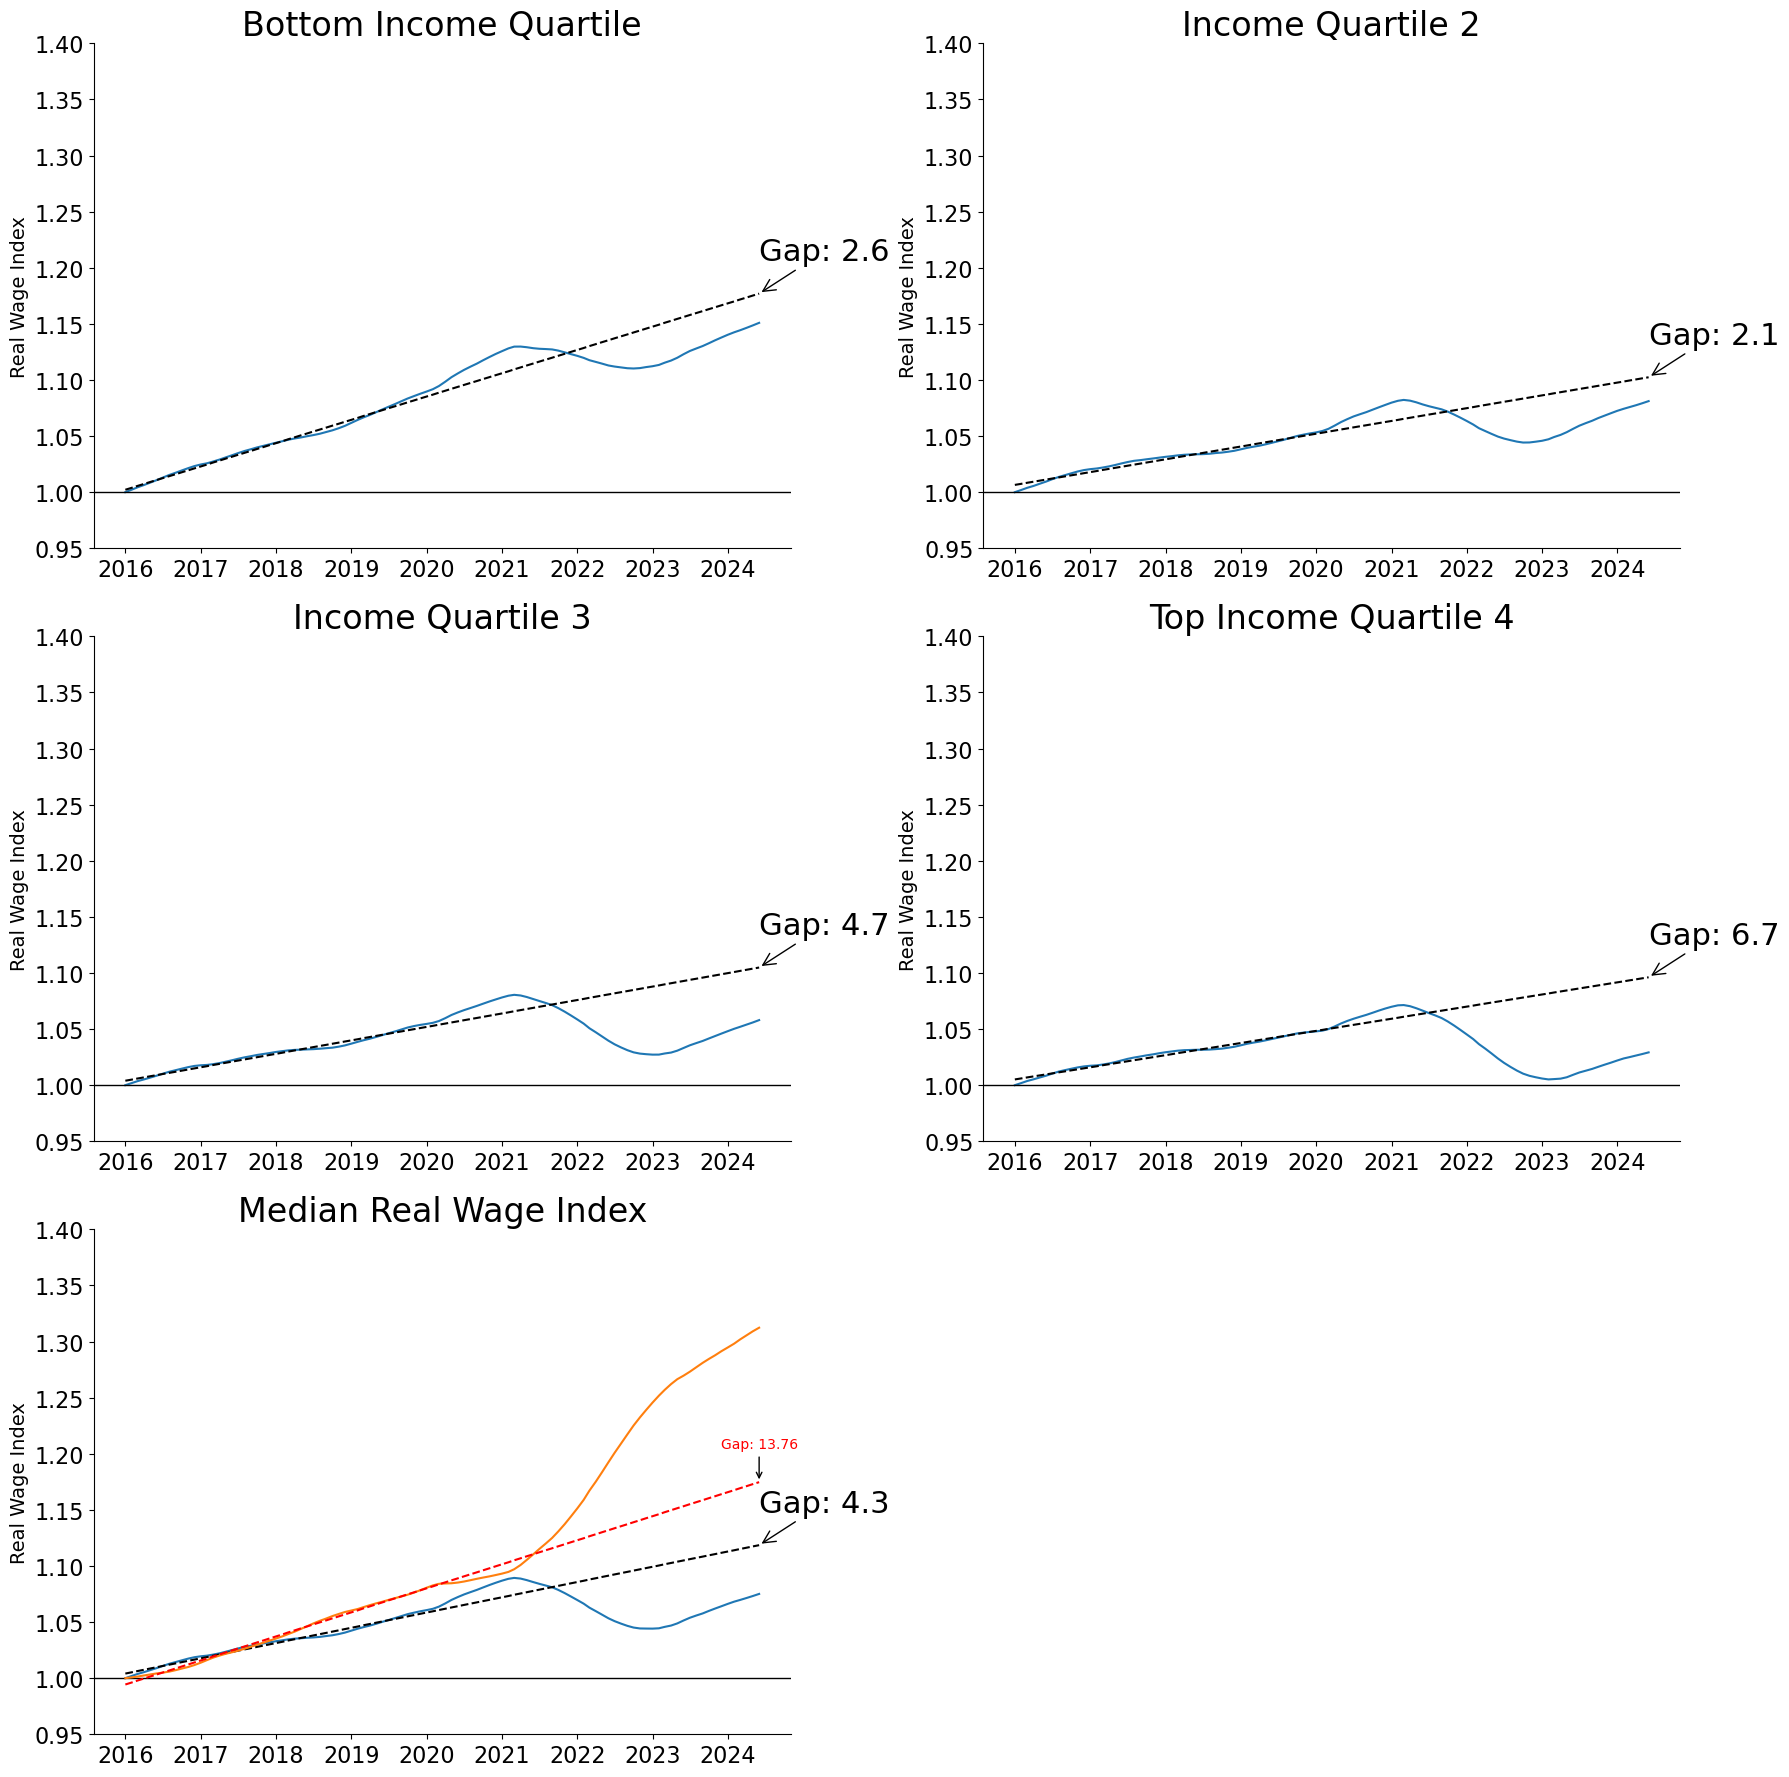

In [49]:

# Assuming wage_data is already defined and includes predicted columns
# Calculate gaps for each index
gaps = {
    'gap_1': wage_data['predicted_real_wage_index_1'].iloc[-1] - wage_data['real_wage_index_1'].iloc[-1],
    'gap_2': wage_data['predicted_real_wage_index_2'].iloc[-1] - wage_data['real_wage_index_2'].iloc[-1],
    'gap_3': wage_data['predicted_real_wage_index_3'].iloc[-1] - wage_data['real_wage_index_3'].iloc[-1],
    'gap_4': wage_data['predicted_real_wage_index_4'].iloc[-1] - wage_data['real_wage_index_4'].iloc[-1],
    'gap_med': wage_data['predicted_med_real_wage_index'].iloc[-1] - wage_data['med_real_wage_index'].iloc[-1],
    'gap_price': wage_data['price_index'].iloc[-1] - wage_data['predicted_price_index'].iloc[-1]
}

# Create five separate plots
plt.figure(figsize=(18, 18))

# Plot for real_wage_index_1
plt.subplot(3, 2, 1)
plt.plot(wage_data['date'], wage_data['real_wage_index_1'], label='Real Wage Index 1')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_1'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Bottom Income Quartile')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_1"] * 100:.1f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=22, color='black', ha='left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(fontsize=16)  
plt.yticks(fontsize=16) 


# Plot for real_wage_index_2
plt.subplot(3, 2, 2)
plt.plot(wage_data['date'], wage_data['real_wage_index_2'], label='Real Wage Index 2')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_2'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 2')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_2"] * 100:.1f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=22, color='black', ha='left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16) 


# Plot for real_wage_index_3
plt.subplot(3, 2, 3)
plt.plot(wage_data['date'], wage_data['real_wage_index_3'], label='Real Wage Index 3')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_3'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 3')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_3"] * 100:.1f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=22, color='black', ha='left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16) 


# Plot for real_wage_index_4
plt.subplot(3, 2, 4)
plt.plot(wage_data['date'], wage_data['real_wage_index_4'], label='Real Wage Index 4')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_4'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Top Income Quartile 4')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_4"] * 100:.1f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=22, color='black', ha='left')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16) 


plt.subplot(3, 2, 5)  # Leave the 5th subplot blank
plt.plot(wage_data['date'], wage_data['med_real_wage_index'])
plt.plot(wage_data['date'], wage_data['predicted_med_real_wage_index'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16) 

plt.title('Median Real Wage Index')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_med"] * 100:.1f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_med_real_wage_index'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_med_real_wage_index'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=22, color='black', ha='left')

plt.plot(wage_data['date'], wage_data['price_index'])
plt.plot(wage_data['date'], wage_data['predicted_price_index'], color='red', linestyle='--', label='Predicted', linewidth=1.5)


plt.annotate(f'Gap: {gaps["gap_price"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_price_index'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_price_index'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Adjust layout
plt.tight_layout()  
plt.savefig(f"{output_dir}/figures/wage_index_trends_short.pdf")


# Export data 
main = ['date', 'price_index', 'predicted_price_index', 
                'med_real_wage_index', 'predicted_med_real_wage_index', 
                'real_wage_index_1', 'predicted_real_wage_index_1', 
                'real_wage_index_2', 'predicted_real_wage_index_2', 
                'real_wage_index_3', 'predicted_real_wage_index_3', 
                'real_wage_index_4', 'predicted_real_wage_index_4']

final = wage_data[main]

final.to_csv(f"{output_dir}/data/real_wage_figures.csv", index = False)